In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from mapping import map_str_values
import mapping
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Xử lý dữ liệu

## Đọc dữ liệu và chuyển biến phân loại dạng string về int

In [2]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
temp_X = X.copy()
mapped_X = map_str_values(X)
# X = remove_categorical_vars(X)
temp_X


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,...,0,0,0,0,0,0,0,0,0,0
669485,17,715,2060,2,0,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
602512,17,51,8163,3,55,6,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


Đọc file labels và chuyển convert damage_grade thành đúng định dạng 0 1 2

In [3]:
Y = pd.read_csv("data/train_labels.csv", index_col="building_id")
temp = {
    1: 0,
    2: 1,
    3: 2
}

Y["damage_grade"] = Y["damage_grade"].map(temp)

---

# Ý tưởng thuật toán

- Giả thiết của Naive Bayes là các feature của dữ liệu độc lập với nhau. Tức là:

   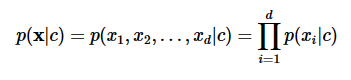

   => Điều này cũng lí giải cho cái tên của thuật toán, vì việc tất cả feature độc lập với nhau ở ngoài thực tế hầu như rất khó xảy ra

- Công thức xác xuất của label c phụ thuộc vào các biến dự đoán:

   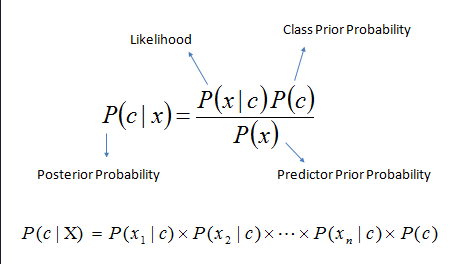

- Từ các xác xuất tính được của mỗi class phụ thuộc vào biến dự đoán, class c được xác định và phân loại bởi xác xuất lớn nhất trong số các xác xuất tính được

   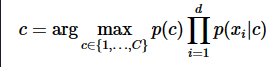

   - Vì tất cả xs P(X) đều giống nhau nên để giảm thiểu số lượng tính toán, ta có thể bỏ đi phần mẫu số (prior predictor)
   

- Tuy nhiên, nếu như dữ liệu có số chiều lớn, các xs sẽ là các số rất bé, khi tính toán có thể gặp sai số, vậy nên để giải quyết vấn đề này, chúng ta thường lấy log của vế phải (log-likelihood)

   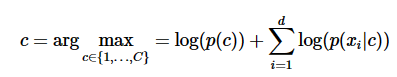

   - Bởi vì hàm log là hàm đồng biến trên tập số dương nên điều này không ảnh hưởng đến kết quả lúc phân loại

***

# Models

***

## Multinomial NB

### - Thường được dùng cho dữ liệu có nhiều biến phân loại (categorical)
### - Ko chấp nhận số âm

- Trong đó ở multinomial NB thì (Px|c) được tính như sau:

   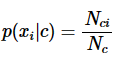

   - Nci: Số lần xuất hiện của phần tử trong class c
   - Nc: Tổng số phần tử (kể cả lặp) xuất hiện trong class c

- Để tránh xảy ra trường hợp xs bằng 0, ta sử dụng Laplace smoothing

   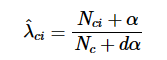

- alpha: số tự chọn (thường là 1)
- d: số feature của dữ liệu

- Áp dụng min max scaler cho data

In [4]:
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(mapped_X)

- Chia train test trực tiếp từ bộ train_values và train_labels

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y , test_size=0.25, random_state=192)
np.unique(Y_train)

array([0, 1, 2], dtype=int64)

In [6]:
mnb = MultinomialNB()
mnb.fit(X_train, Y_train["damage_grade"])

MultinomialNB()

- ma trận bối rối

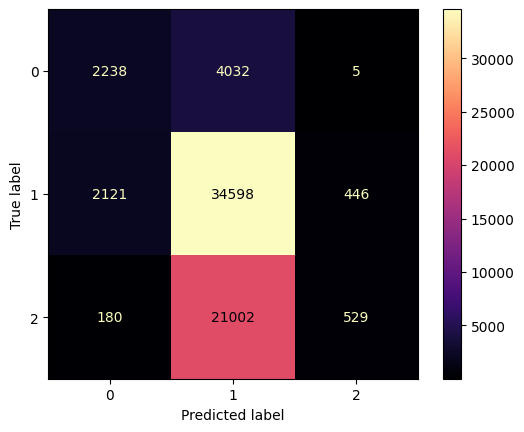

In [7]:
Y_pred = mnb.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm).plot(cmap="magma")

- Số liệu

In [8]:
print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.36      0.41      6275
           1       0.58      0.93      0.71     37165
           2       0.54      0.02      0.05     21711

    accuracy                           0.57     65151
   macro avg       0.54      0.44      0.39     65151
weighted avg       0.56      0.57      0.46     65151



---

## Gaussian Naive Bayes

### - Thường được dùng để xử lý các dữ liệu dạng liên tục (continuous data)
### => Dữ liệu nên được scale về theo Standard Scaler

- Do Gaussian xử lý các dữ liệu liên tục nên ko thể tính các xs P(X|C) theo cách thông thường được, mà thay vào đó xs này phụ thuộc vào mean và var của các feature ứng với mỗi class

   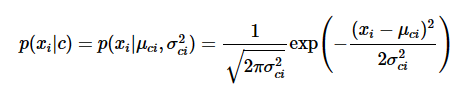

=> Hàm trên chính là hàm mật độ xs của pp Gaussian

- Áp dụng StandardScaler cho data

In [9]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(mapped_X)

- Chia lại train test

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y , test_size=0.25, random_state=192)
np.unique(Y_train)

array([0, 1, 2], dtype=int64)

In [11]:
gaussNB = GaussianNB()
gaussNB.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

- Predict

In [12]:
Y_pred = gaussNB.predict(X_test)
Y_pred

array([0, 2, 1, ..., 2, 1, 0], dtype=int64)

- Ma trận bối rối

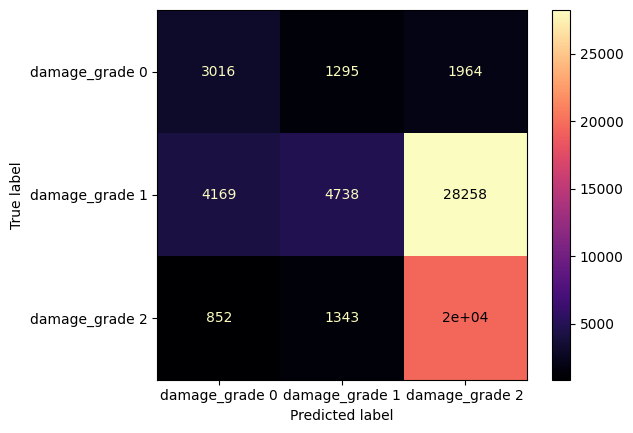

In [13]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(cmap="magma")

- So sánh Số liệu của kết quả 

In [14]:
print(metrics.classification_report(Y_test, Y_pred, target_names=["damage_grade 0", "damage_grade 1", "damage_grade 2"]))

                precision    recall  f1-score   support

damage_grade 0       0.38      0.48      0.42      6275
damage_grade 1       0.64      0.13      0.21     37165
damage_grade 2       0.39      0.90      0.55     21711

      accuracy                           0.42     65151
     macro avg       0.47      0.50      0.39     65151
  weighted avg       0.53      0.42      0.34     65151



***

## Bernouli Naive Bayes

### - Thường được dùng cho bộ dữ liệu có nhiều trường binary (T/F)
### - Hoạt động khá tốt với dữ liệu imbalanced

- P(X|C) tuân theo hàm mật độ xs nhị thức:

    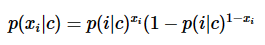

    - P(i|c): Xs phần tử thứ i xuất hiện trong các dữ liệu thuộc class c

- Do các biến phân loại có thể biểu diễn dưới dạng binary và ngược lại, ta có thể sử dụng one hot encode cho dữ liệu phù hợp hơn đối với mô hình

In [15]:
encoded_X = pd.get_dummies(temp_X)
encoded_X.shape

(260601, 68)

- Chia train, test lại

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(encoded_X, Y , test_size=0.25, random_state=192)
np.unique(Y_train)

array([0, 1, 2], dtype=int64)

In [17]:
bernNB = BernoulliNB()
bernNB.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB()

In [18]:
Y_pred = bernNB.predict(X_test)
Y_pred.shape

(65151,)

In [24]:
bernNB.predict_joint_log_proba(X_test)

array([[-26.82658831, -33.02016867, -41.45175404],
       [-12.47556002,  -5.22507498,  -4.86388402],
       [-32.80240623, -29.65096065, -32.93816076],
       ...,
       [-12.47556002,  -5.22507498,  -4.86388402],
       [-19.36983935, -25.39575626, -33.03403841],
       [-17.64864459, -30.25430499, -44.98930236]])

In [25]:
bernNB.predict_log_proba(X_test)

array([[-2.04086179e-03, -6.19562122e+00, -1.46272066e+01],
       [-8.14073865e+00, -8.90253606e-01, -5.29062651e-01],
       [-3.22854414e+00, -7.70985574e-02, -3.36429867e+00],
       ...,
       [-8.14073865e+00, -8.90253606e-01, -5.29062651e-01],
       [-2.41358422e-03, -6.02833049e+00, -1.36666126e+01],
       [-3.35297791e-06, -1.26056638e+01, -2.73406611e+01]])

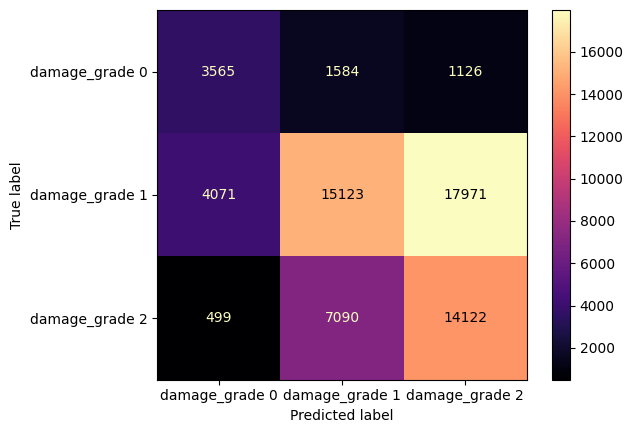

In [20]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot(cmap="magma")

In [21]:
print(metrics.classification_report(Y_test, Y_pred, target_names=["damage_grade 0", "damage_grade 1", "damage_grade 2"]))

                precision    recall  f1-score   support

damage_grade 0       0.44      0.57      0.49      6275
damage_grade 1       0.64      0.41      0.50     37165
damage_grade 2       0.43      0.65      0.51     21711

      accuracy                           0.50     65151
     macro avg       0.50      0.54      0.50     65151
  weighted avg       0.55      0.50      0.50     65151



# Accuracy trung bình:

In [22]:
(0.57 + 0.42 + 0.53)/3

0.5066666666666667